# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks

 database.sqlite   KNN.ipynb		        NB.ipynb      SVM.ipynb
 DT.ipynb	  'Logistic Regression.ipynb'   Reviews.csv   Untitled2.ipynb


In [0]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Reviews.csv')

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
conn=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite')

In [0]:
filter_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""",conn)

In [0]:
def partition (x):
  if x<3:
    return 0
  return 1

In [0]:
actualscore = filter_data['Score']
positivenegative = actualscore.map(partition)
filter_data['Score']= positivenegative
print('Nomber of data points in our data',filter_data.shape)
filter_data.head(5)

Nomber of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filter_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filter_data['Id'].size*1.0)*100

87.775

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## [3] Preprocessing

### [3.1]. Preprocessing Review Text

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:33<00:00, 2587.48it/s]


In [0]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [5] Assignment 5: Apply Logistic Regression

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW

In [0]:
X=preprocessed_reviews
y=np.array(final['Score'])

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train =count_vect.transform(X_train)
X_cv = count_vect.transform(X_cv)
X_test = count_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (56174, 44456)
Test Data Size:  (17555, 44456)
CV Data Size : (14044, 44456)


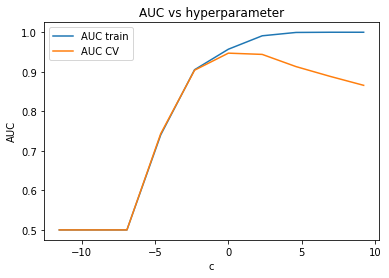

optimal c for which auc is maximum :  1


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import math

c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l1',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

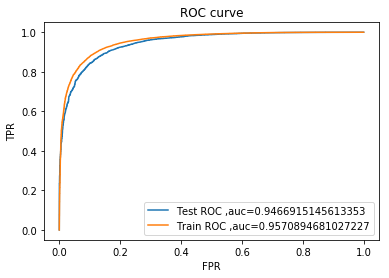

AUC on Test data is 0.9466915145613353
AUC on Train data is 0.9570894681027227
---------------------------


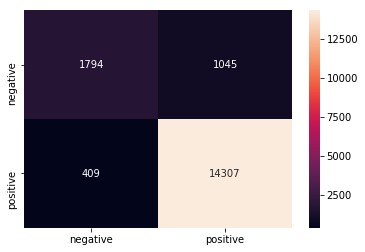

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l1',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")



In [0]:
results=pd.DataFrame(columns=['Featuraization', 'Classifier' ,'penalty','C', 'Train-AUC', 'Test-AUC' ])
new = ['BOW','LogisticRegression','l1',1,0.9570,0.9466]
results.loc[0] = new

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW 

In [0]:
clf = LogisticRegression(penalty='l1',C=optimal_c)
clf.fit(X_train,y_train)
weight = clf.coef_
#Sparsity of vector weight=no of zero in weight vector
print('No of non zero element in weight vector ',np.count_nonzero(weight))

No of non zero element in weight vector  1091


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW

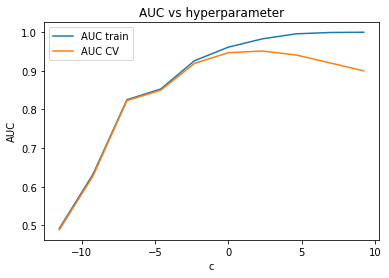

optimal c for which auc is maximum :  10


In [0]:
c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l2',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

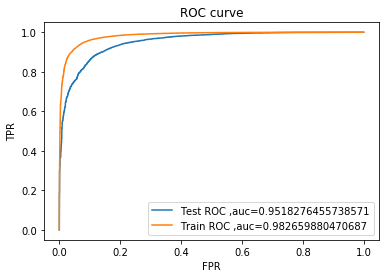

AUC on Test data is 0.9518276455738571
AUC on Train data is 0.982659880470687
---------------------------


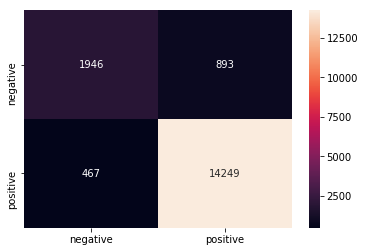

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l2',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")


In [0]:
new = ['BOW','LogisticRegression','l2',10,0.9826,0.9518]
results.loc[1] = new

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW

In [0]:
#for checking multicollinearity we add e(small value) to train vector
W_before = clf.coef_
X_e = X_train
X_e.data = X_e.data+np.random.normal(loc=0,scale=0.0001,size=X_e.data.shape)
X_e.shape

(56174, 44456)

In [0]:
#Training Logistic regression with X_e

clf_e = LogisticRegression(penalty='l2',C=optimal_c,)
clf_e.fit(X_e,y_train)
W_after = clf_e.coef_

#to eliminate divisible by zero error we will add 10^-6 to W_before and W_after
W_before+=10**-6
W_after+=10**-6

per_vector=[]

for i in range(len(W_before[0])):
    val = W_after[0][i]-W_before[0][i]
    val/=W_before[0][i]
    per_vector.append(val)
    
original_per_vect=np.absolute(per_vector)    
per_vector=sorted(np.absolute(per_vector))[::-1]

#percentage change in vectors

per_vector[:10]

[14.80857510131174,
 6.6254089326605685,
 4.039013940139834,
 3.9324261182040177,
 2.1529892119272054,
 1.9361352311080053,
 1.7068771216757437,
 1.3879749537211359,
 1.118580374901707,
 0.8092491650052873]

In [0]:
#calculating percentiles from 0 to 100
for i in range(11):
    print(str(i*10)+'th percentile = '+str(np.percentile(per_vector,i*10)))

0th percentile = 5.2619260057978866e-09
10th percentile = 0.00014675450634988148
20th percentile = 0.00031089452303914263
30th percentile = 0.00048679710979011956
40th percentile = 0.0006939040580330754
50th percentile = 0.0009473257919403952
60th percentile = 0.0012485310096128726
70th percentile = 0.00165108613351234
80th percentile = 0.0022697121805277188
90th percentile = 0.0034649799671194366
100th percentile = 14.80857510131174


In [0]:
#there is sudden rise in percentile from 90 to 100
#calculating percentile from 90 to 100
for i in range(90,101):
    print(str(i)+'th percentile ='+str(np.percentile(per_vector,i)))

90th percentile =0.0034649799671194366
91th percentile =0.003674724913295412
92th percentile =0.003918123848788227
93th percentile =0.004220783497203643
94th percentile =0.00458200991714935
95th percentile =0.005101224470454821
96th percentile =0.0058410945621891214
97th percentile =0.007066721610503791
98th percentile =0.009630575638687765
99th percentile =0.018018126061825818
100th percentile =14.80857510131174


In [0]:
#from 99th percentile to 100 percentile sudden rise in the values from 0.01 to 14.80
#calculating percentile from 99.1 to 100
for i in range(1,11):
    print(str(99+(10**-1)*i)+'th percentile ='+str(np.percentile(per_vector,99+(10**-1)*i)))

99.1th percentile =0.020117384507674467
99.2th percentile =0.02249790245124466
99.3th percentile =0.025447564051417425
99.4th percentile =0.028630339963991162
99.5th percentile =0.035192954198076165
99.6th percentile =0.04577707798515614
99.7th percentile =0.06366603239170668
99.8th percentile =0.0957254273892008
99.9th percentile =0.19551911944602463
100.0th percentile =14.80857510131174


In [0]:
#finding features from 99.9th percentile to 100th percentile
print('Features from 99.9th percentile to 100th percentile')
for i in range(1,11):
    print(str(99.9+(10**-2)*i)+'th percentile ='+str(np.percentile(per_vector,99.9+(10**-2)*i)))
   
  
original_per_vect = original_per_vect
all_features = count_vect.get_feature_names()
indx=original_per_vect.index(14.80857510131174)
print(all_features[indx])


Features from 99.9th percentile to 100th percentile
99.91000000000001th percentile =0.21376381538485728
99.92th percentile =0.23091936186697343
99.93th percentile =0.2798644099732516
99.94000000000001th percentile =0.33692339771401403
99.95th percentile =0.3704759714127028
99.96000000000001th percentile =0.48563355295442845
99.97th percentile =0.6370194605652426
99.98th percentile =0.8429662668852395
99.99000000000001th percentile =2.0563807634734763
100.0th percentile =14.80857510131174
luckily


### [5.1.3] Feature Importance on BOW

#### [5.1.3.1] Top 10 important features of positive class

In [0]:
weight = clf.coef_
pos_indx = np.argsort(weight)[:,::-1]

neg_indx = np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])
    

Top 10 positive features :
amazing
perfect
hooked
delicious
awesome
yummy
excellent
wonderful
complaint
pleasantly


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
print('Top 10 negative features :')
for i in list(neg_indx[0][:10]):
    print(all_features[i])

Top 10 negative features :
worst
terrible
awful
disappointing
disappointment
rip
tasteless
threw
died
horrible


## [5.2] Logistic Regression on TFIDF

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train = tf_idf_vect.transform(X_train)
X_cv = tf_idf_vect.transform(X_cv)
X_test = tf_idf_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

X_cv = preprocessing.normalize(X_cv)
print("CV Data Size :", X_cv.shape)

Train Data Size:  (56174, 33360)
Test Data Size:  (17555, 33360)
CV Data Size : (14044, 33360)


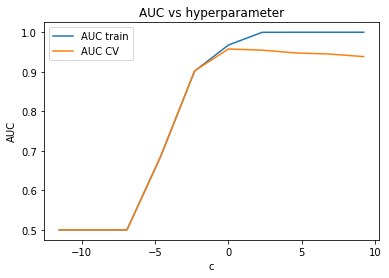

optimal c for which auc is maximum :  1


In [0]:
c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l1',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

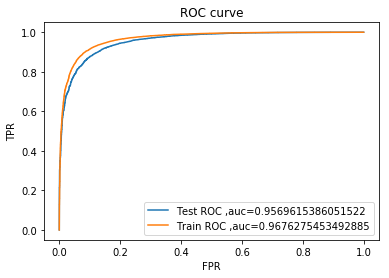

AUC on Test data is 0.9569615386051522
AUC on Train data is 0.9676275453492885
---------------------------


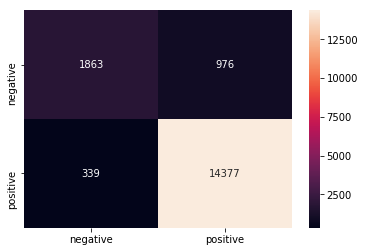

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l1',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")


In [0]:
new = ['tf_idf','LogisticRegression','l1',1,0.9676,0.9569]
results.loc[2] = new

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

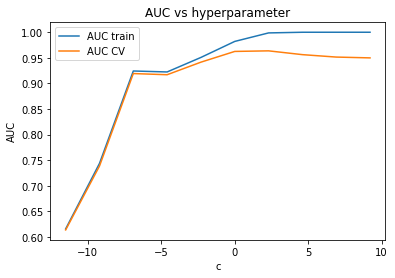

optimal c for which auc is maximum :  10


In [0]:
c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l2',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)# Please write all the code with proper documentation

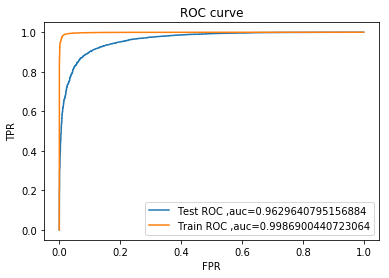

AUC on Test data is 0.9629640795156884
AUC on Train data is 0.9986900440723064
---------------------------


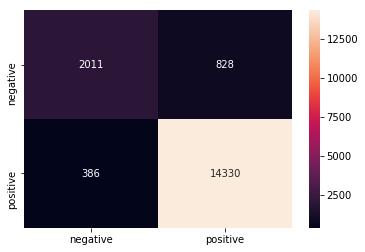

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l2',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['tf_idf','LogisticRegression','l2',10,0.9986,0.9629]
results.loc[3] = new

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
all_features = tf_idf_vect.get_feature_names()
weight = clf.coef_
pos_indx = np.argsort(weight)[:,::-1]

neg_indx = np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
delicious
not disappointed
perfect
good
best
loves
wonderful
nice
excellent


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
print('Top 10 negative features :')
for i in list(neg_indx[0][:10]):
    print(all_features[i])

Top 10 negative features :
worst
disappointed
not worth
not good
not recommend
awful
terrible
two stars
disappointing
weak


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 56174/56174 [01:44<00:00, 538.95it/s]

56174
50


In [0]:
#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

100%|██████████| 14044/14044 [00:27<00:00, 511.14it/s]

14044
50


In [0]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 17555/17555 [00:32<00:00, 541.59it/s]

17555
50


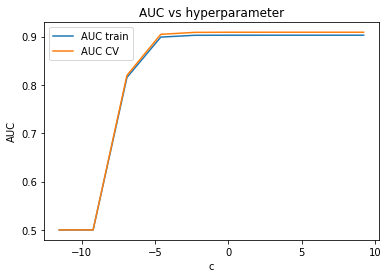

optimal c for which auc is maximum :  100


In [0]:
X_train = sent_vectors_train
X_cv = sent_vectors_cv
X_test = sent_vectors_test

c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l1',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

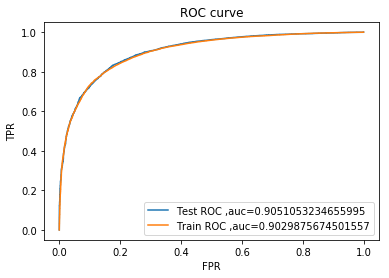

AUC on Test data is 0.9051053234655995
AUC on Train data is 0.9029875674501557
---------------------------


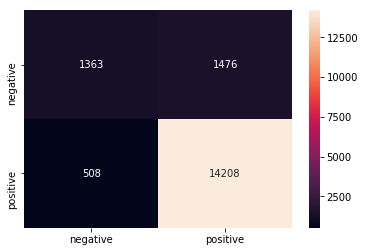

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l1',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")


In [0]:
new = ['AVG W2V','LogisticRegression','l1',100,0.9029,0.9051]
results.loc[4] = new

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

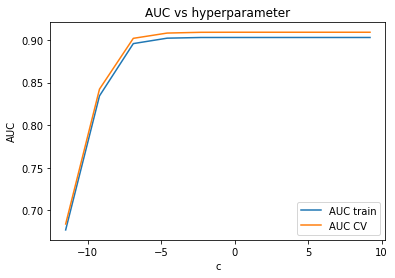

optimal c for which auc is maximum :  1


In [0]:
c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l2',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)# Please write all the code with proper documentation

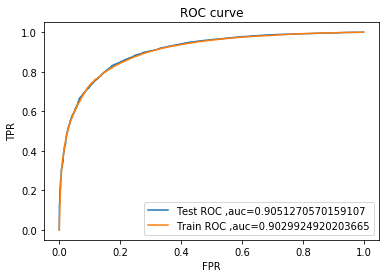

AUC on Test data is 0.9051270570159107
AUC on Train data is 0.9029924920203665
---------------------------


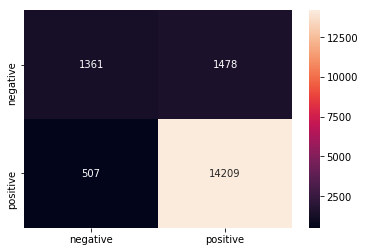

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l2',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['AVG W2V','LogisticRegression','l2',1,0.9029,0.9051]
results.loc[5] = new

## [5.4] Logistic Regression on TFIDF W2V

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V

In [0]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1



100%|██████████| 56174/56174 [02:29<00:00, 376.97it/s]


In [0]:
#for cross validation data and test we will use same words and models of train
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 14044/14044 [00:38<00:00, 367.76it/s]


In [0]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 17555/17555 [00:46<00:00, 378.04it/s]


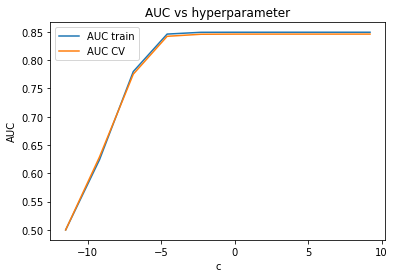

optimal c for which auc is maximum :  10000


In [0]:
X_train = tfidf_sent_vectors_train
X_cv = tfidf_sent_vectors_cv
X_test = tfidf_sent_vectors_test

c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l1',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)

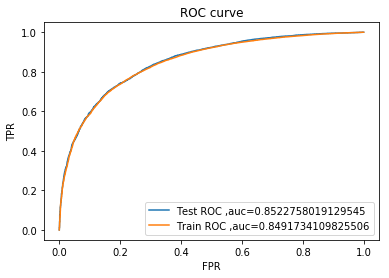

AUC on Test data is 0.8522758019129545
AUC on Train data is 0.8491734109825506
---------------------------


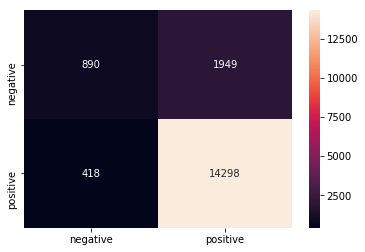

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l1',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")


In [0]:
new = ['TFIDF W2V','LogisticRegression','l1',10000,0.8489,0.8522]
results.loc[6] = new

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

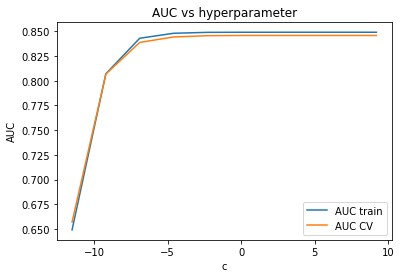

optimal c for which auc is maximum :  100


In [0]:
c = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

train_auc = []
cv_auc = []

for i in c:
    clf = LogisticRegression(penalty='l2',C=i)
    clf.fit(X_train,y_train)
    prob_cv = clf.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,prob_cv))
    prob_train = clf.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,prob_train))
optimal_c= c[cv_auc.index(max(cv_auc))]
c = [math.log(x) for x in c]

#plot auc vs alpha
x = plt.subplot( )
x.plot(c, train_auc, label='AUC train')
x.plot(c, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('c')
plt.ylabel('AUC')
x.legend()
plt.show()

print('optimal c for which auc is maximum : ',optimal_c)# Please write all the code with proper documentation

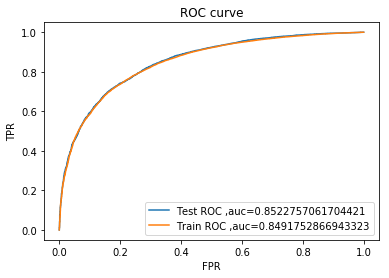

AUC on Test data is 0.8522757061704421
AUC on Train data is 0.8491752866943323
---------------------------


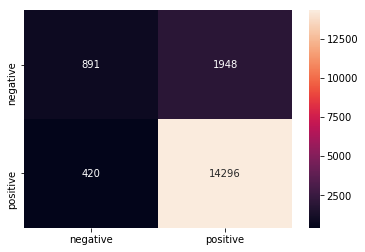

In [0]:
#Testing AUC on Test data
clf = LogisticRegression(penalty='l2',C=optimal_c)
clf.fit(X_train,y_train)
pred_test = clf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_test)
pred_train = clf.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred_train) 


#plot ROC curve
x = plt.subplot( )
x.plot(fpr1, tpr1, label ='Test ROC ,auc='+str(roc_auc_score(y_test,pred_test)))
x.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred_train)))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
x.legend()
plt.show()

print("AUC on Test data is " +str(roc_auc_score(y_test,pred_test)))
print("AUC on Train data is " +str(roc_auc_score(y_train,pred_train)))

print("---------------------------")

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [0]:
new = ['TFIDF W2V','LogisticRegression','l2',100,0.8491,0.8522]
results.loc[7] = new

## Performance Table

In [0]:
results

,Featuraization,Classifier,penalty,C,Train-AUC,Test-AUC
0,BOW,LogisticRegression,l1,1,0.9570,0.9466
1,BOW,LogisticRegression,l2,10,0.9826,0.9518
2,tf_idf,LogisticRegression,l1,1,0.9676,0.9569
3,tf_idf,LogisticRegression,l2,10,0.9986,0.9629
4,tf_idf,LogisticRegression,l1,100,0.9029,0.9051
5,AVG W2V,LogisticRegression,l2,1,0.9029,0.9051
6,TFIDF W2V,LogisticRegression,l1,10000,0.8489,0.8522
7,TFIDF W2V,LogisticRegression,l2,100,0.8491,0.8522


# [6] Conclusions

1. Logistic Regression is one of the best algorithm

2. It works very well if we have large amount of data with high dimensionality

3. Time complexity is very low

4. Logistic Regression gave best AUC Score = 0.9629 with tf_idf featuraization, l2 penalty and C = 10